# NCAA Pitch Type Model

### By: Jiso Awe


This project was intended to create a more accurate version of TrackMan's auto pitch type model, this is specifically tailored to college players.

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('seaborn-whitegrid')
from sklearn.neighbors import KNeighborsClassifier

In [100]:
data = pd.read_csv('NCAA_Pitch.csv')
data.head(5)

,id,PitchNo,Date,Time,PAofInning,PitchofPA,PitcherId,PitcherThrows,PitcherTeam,BatterId,...,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence,GameID
0,6,6,2021-04-07,15:03:45,1,6,1.000080e+09,Right,TOW_TIG,1.000059e+09,...,NaN,High,High,High,Medium,Medium,NaN,NaN,NaN,57
1,16,16,2021-04-07,15:08:11,3,4,1.000080e+09,Right,TOW_TIG,1.000101e+09,...,NaN,High,High,High,High,High,NaN,NaN,NaN,57
2,32,32,2021-04-07,15:16:17,3,4,1.000025e+09,Right,NAV_MID,1.000059e+09,...,NaN,High,High,High,High,High,NaN,NaN,NaN,57
3,34,34,2021-04-07,15:18:22,1,2,1.000080e+09,Right,TOW_TIG,1.000013e+09,...,NaN,High,High,High,Medium,High,NaN,NaN,NaN,57
4,38,38,2021-04-07,15:19:48,2,4,1.000080e+09,Right,TOW_TIG,1.000059e+09,...,NaN,High,High,High,Medium,Medium,NaN,NaN,NaN,57


In [41]:
#list(data.columns)

For the in depth descriptions of each of these metrics visit Trackman's metric glossary: https://support.trackmanbaseball.com/hc/en-us/articles/5089413493787-V3-FAQs-Radar-Measurement-Glossary-Of-Terms

# Exploratory Data Analysis
### Movement Plots

I created the movement plots for both left and right handed pitchers, to highlight the difference in their movement profiles. Traditionally in baseball, velocity in combination with horizontal and induced vertical break are used to identify pitch type.

Left and right handed pitchers have opposite horizontal movements patterns so I will be creating seperate visualizations to highlight the differences in the movement patterns.

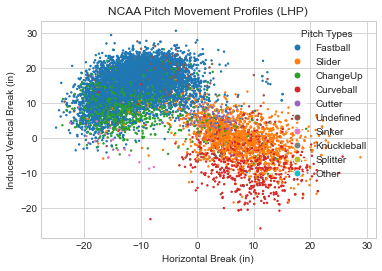

<Figure size 864x576 with 0 Axes>

In [254]:
#leftie pitch plots
dataL = data[data['PitcherThrows'] == "Left"]
xL = dataL['HorzBreak']
yL = dataL['InducedVertBreak']
zL = dataL['TaggedPitchType']

pitch_types = zL.unique()

color_map = plt.get_cmap('tab10')
color_dict = {pitch_type: color_map(i) for i, pitch_type in enumerate(pitch_types)}

color_values = [color_dict[pitch_type] for pitch_type in zL]


scatter = plt.scatter(xL, yL, c = color_values, s = 2, label = zL)

plt.title("NCAA Pitch Movement Profiles (LHP)")
plt.ylabel("Induced Vertical Break (in)")
plt.xlabel("Horizontal Break (in)")

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map(i / len(pitch_types)), markersize=7) for i, pitch_type in enumerate(pitch_types)]
labels = pitch_types
plt.legend(handles, labels, title = 'Pitch Types')
plt.figure(figsize = (12, 8))
plt.show()

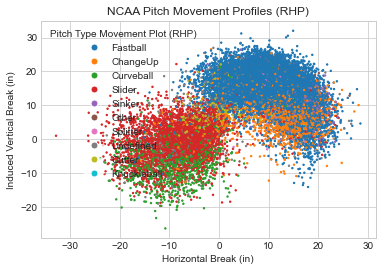

<Figure size 864x576 with 0 Axes>

In [255]:
#rightie pitch plots
dataR = data[data['PitcherThrows'] == "Right"]
xR = dataR['HorzBreak']
yR = dataR['InducedVertBreak']
zR = dataR['TaggedPitchType']

pitch_types = zR.unique()

color_map = plt.get_cmap('tab10')
color_dict = {pitch_type: color_map(i) for i, pitch_type in enumerate(pitch_types)}

color_values = [color_dict[pitch_type] for pitch_type in zR]


scatter = plt.scatter(xR, yR, c = color_values, s = 2, label = zR)

plt.title("NCAA Pitch Movement Profiles (RHP)")
plt.ylabel("Induced Vertical Break (in)")
plt.xlabel("Horizontal Break (in)")

handles = [plt.Line2D([0], [0], marker='o', 
                      color='w', 
                      markerfacecolor=color_map(i / len(pitch_types)), 
                      markersize=7) for i, 
           pitch_type in enumerate(pitch_types)]

labels = pitch_types
plt.legend(handles, labels, title = 'Pitch Type Movement Plot (RHP)')
plt.figure(figsize = (12, 8))
plt.show()

## Preprocessing

In [101]:
#Updating the data to include only the pitching related columns
cols = ['PitcherThrows', 'RelSpeed', 'VertRelAngle', 'HorzRelAngle', 'SpinRate', 'SpinAxis',
            'RelHeight', 'RelSide', 'Extension', 'VertBreak', 'InducedVertBreak', 'HorzBreak', 'ZoneSpeed',
           'VertApprAngle', 'HorzApprAngle', 'PitchTrajectoryXc0','PitchTrajectoryXc1', 'PitchTrajectoryXc2',
            'PitchTrajectoryYc0', 'PitchTrajectoryYc1', 'PitchTrajectoryYc2', 'PitchTrajectoryZc0',
            'PitchTrajectoryZc1','PitchTrajectoryZc2', 'TaggedPitchType', 'Tilt']

updated_df = data[cols]


In [102]:
updated_df.head(5)

,PitcherThrows,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,RelHeight,RelSide,Extension,VertBreak,...,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,TaggedPitchType,Tilt
0,Right,87.7942,-2.316140,-1.48219,2074.21,193.273,6.39639,1.25232,5.62407,-14.4967,...,-128.294,14.9429,6.39219,-5.07470,-5.88970,-1.25003,3.25817,-2.44303,Fastball,12:30:00
1,Right,78.6510,-3.237650,-2.15585,1743.14,176.354,6.21378,1.55537,5.58387,-20.2948,...,-114.773,12.5362,6.20956,-6.39518,-6.43732,-1.55554,4.33739,0.04007,ChangeUp,12:00:00
2,Right,83.7694,-0.945851,-3.61505,2063.13,194.331,5.58439,2.96050,6.79323,-21.0996,...,-122.319,13.0979,5.58271,-1.97702,-8.59524,-2.95833,7.68082,-2.47728,Fastball,12:30:00
3,Right,87.2288,-2.433030,-1.51020,2049.19,183.578,6.36527,1.16780,5.48250,-12.4688,...,-127.431,15.7290,6.36003,-5.26725,-4.85992,-1.16691,3.34104,-1.01793,Fastball,12:00:00
4,Right,88.3147,-3.345550,-1.49199,2083.12,195.554,6.32208,1.41026,5.61121,-13.4307,...,-128.939,15.3537,6.31744,-7.41420,-5.19747,-1.40755,3.28298,-2.93283,Fastball,12:30:00


In [103]:
# conversion for HB + HorzApprAngle and then implement this back into the OG DF, THEN run the models
def left_to_right_movement(data):
    tilt_mapping = {
        '11:45:00':'12:15:00','11:30:00': '12:30:00','11:15:00':'12:45:00','11:00:00':'01:00:00', 
        '10:45:00':'01:15:00', '10:30:00':'01:30:00','10:15:00':'01:45:00','10:00:00':'02:00:00',
        '09:45:00':'02:15:00','09:30:00':'02:30:00','09:15:00':'02:45:00','09:00:00':'03:00:00',
        '08:45:00':'03:15:00','08:30:00':'03:30:00','08:15:00':'03:45:00','08:00:00':'04:00:00',
        '07:45:00':'04:15:00','07:30:00':'04:30:00','07:15:00':'04:45:00','07:00:00':'05:00:00',
        '06:45:00':'05:15:00','06:30:00':'05:30:00','06:15:00':'05:45:00',
        '05:45:00':'06:15:00','05:30:00':'06:30:00','05:15:00':'06:45:00','05:00:00':'07:00:00',
        '04:45:00':'07:15:00','04:30:00':'07:30:00','04:15:00':'07:45:00','04:00:00':'08:00:00',
        '03:45:00':'08:15:00','03:30:00':'08:30:00','03:15:00':'08:45:00','03:00:00':'09:00:00',
        '02:45:00':'09:15:00','02:30:00':'09:30:00','02:15:00':'09:45:00','02:00:00':'10:00:00',
        '01:45:00':'10:15:00','01:30:00':'10:30:00','01:15:00':'10:45:00','01:00:00':'11:00:00'}
    
    if data['PitcherThrows'].iloc[0] == 'Left':
        data['Tilt'] = data['Tilt'].map(tilt_mapping)
        
    for col in ['HorzBreak', 'RelSide', 'HorzRelAngle', 'HorzApprAngle', 'PitchTrajectoryZc0', 'PitchTrajectoryZc1', 'PitchTrajectoryZc2']:
        if col in data.columns:
            data[col] = data[col]*-1
            
    data = data.drop('PitcherThrows', axis=1)
    return data



In [104]:
data = left_to_right_movement(updated_df)

<ipython-input-103-5b0e0ba3ea47>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col]*-1


In [105]:
#data.head(5)

In [106]:
data['Tilt_minutes'] = (pd.to_timedelta(data['Tilt']).dt.total_seconds())/60
updated_df = data.drop("Tilt", axis = 1)
updated_df.dropna(inplace=True)

## Model Evaluation (Part 1)

Here I wanted to examine various models and see what their performance looks like after encoding desired categorical metrics. Categorical data is important to have included here because it can provide some further context to the model, which will impact the models ability to learn and make accurate predictions.

In [107]:
y = updated_df['TaggedPitchType']
X = updated_df.drop('TaggedPitchType', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 22)

#### KNN

In [108]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
y_train_pred = knn.predict(X_train)
y_pred_knn = knn.predict(X_test)

print("Training Accuracy: ", accuracy_score(y_train, y_train_pred))
print("Test Accuracy: ", accuracy_score(y_test, y_pred_knn))

Training Accuracy:  0.8481401227880101
Test Accuracy:  0.7975300617484563


#### SVM

In [109]:
svc = SVC(kernel = 'rbf', random_state = 2)
svc.fit(X_train, y_train)
y_train_SVC = svc.predict(X_train)
y_pred_SVC = svc.predict(X_test)

print("Training Accuracy: ", accuracy_score(y_train, y_train_SVC))
print("Test Accuracy: ", accuracy_score(y_test, y_pred_SVC))

Training Accuracy:  0.7689779703864211
Test Accuracy:  0.7583143754739465


#### Naive Bayes

In [110]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)
y_train_nb = gnb.predict(X_train)

print("Training Accuracy: ", accuracy_score(y_train, y_train_nb))
print("Test Accuracy: ", accuracy_score(y_test, y_pred_gnb))

Training Accuracy:  0.7202600216684724
Test Accuracy:  0.72083197920052


#### Decision Tree

In [111]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
y_train_dt = dt.predict(X_train)

print("Training Accuracy: ", accuracy_score(y_train, y_train_dt))
print("Test Accuracy: ", accuracy_score(y_test, y_pred_dt))

Training Accuracy:  1.0
Test Accuracy:  0.7896219261185137


The accuracy scores are lower than I had anticipated and so I decided to look into the distribution of the pitch type data for further insight.

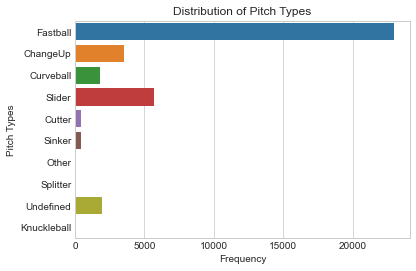

In [200]:
sns.countplot(y = one_hot_encoded_data['TaggedPitchType'])
plt.title('Distribution of Pitch Types')
plt.xlabel('Frequency')
plt.ylabel('Pitch Types')
plt.show()

Generally, when one is referring to the "fastball", they are talking about the four-seam fastball. The sinker is a two-seam fastball and at the collegiate level, many people just refer to sinkers as fastballs. The distinction between the two pitch types comes from the way that the pitcher orients the seams of the ball when throwing it. The sinker tends to have more horizontal movement / armside movement (run). Opposed to the traditional four-seam fastball which has more vertical movement and is more resistant to "dropping" (ride).

For the purposes of this project, seeing as I'm trying to predict college pitch types, I'll be categorizing sinkers as fastballs. Additionally, due to the data imbalance for certain pitch types (Other, Splittler, Undefined, and Knuckleball), these pitch types will be excluded from the dataset to ensure more reliable model performance. 

In [112]:
# function to remove uncommon pitch types
def pitch_type_adjust(data):
    data['TaggedPitchType'] = data['TaggedPitchType'].replace('Sinker', 'Fastball')
        
    nope = ['Other', 'Splitter', 'Undefined', 'Knuckleball']
    data[~data['TaggedPitchType'].isin(nope)]
        
    return data
    

In [113]:
pitch_type_adjust(updated_df)

,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,...,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,TaggedPitchType,Tilt_minutes
0,87.7942,-2.316140,1.48219,2074.21,193.2730,6.39639,-1.25232,5.62407,-14.4967,22.71110,...,-128.294,14.9429,6.39219,-5.07470,-5.88970,1.25003,-3.25817,2.44303,Fastball,750.0
1,78.6510,-3.237650,2.15585,1743.14,176.3540,6.21378,-1.55537,5.58387,-20.2948,26.51700,...,-114.773,12.5362,6.20956,-6.39518,-6.43732,1.55554,-4.33739,-0.04007,ChangeUp,720.0
2,83.7694,-0.945851,3.61505,2063.13,194.3310,5.58439,-2.96050,6.79323,-21.0996,17.81280,...,-122.319,13.0979,5.58271,-1.97702,-8.59524,2.95833,-7.68082,2.47728,Fastball,750.0
3,87.2288,-2.433030,1.51020,2049.19,183.5780,6.36527,-1.16780,5.48250,-12.4688,25.74060,...,-127.431,15.7290,6.36003,-5.26725,-4.85992,1.16691,-3.34104,1.01793,Fastball,720.0
4,88.3147,-3.345550,1.49199,2083.12,195.5540,6.32208,-1.41026,5.61121,-13.4307,23.49540,...,-128.939,15.3537,6.31744,-7.41420,-5.19747,1.40755,-3.28298,2.93283,Fastball,750.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37054,77.8320,0.487803,-3.79674,1629.89,89.1505,4.96262,1.48449,6.13498,-44.7470,1.22839,...,-113.748,10.7878,4.96757,0.83277,-15.51590,-1.47783,7.37037,-7.06468,ChangeUp,540.0
37055,91.9834,-3.016400,-2.31560,2055.19,160.8450,6.28585,1.78022,6.68517,-10.5206,22.21320,...,-134.281,17.1792,6.28117,-6.94342,-4.54720,-1.77695,5.33487,-4.07897,Fastball,675.0
37056,91.0094,-2.001200,-1.25103,2068.34,164.7750,6.39009,1.82484,6.42173,-15.1611,18.67500,...,-132.998,17.3268,6.38689,-4.55699,-6.78894,-1.82261,2.84045,-2.49379,Fastball,690.0
37057,92.2731,-3.173200,-2.67958,2148.68,154.7450,6.25661,1.89786,6.70419,-11.4928,20.70590,...,-134.710,15.8895,6.25298,-7.36801,-5.08098,-1.89428,6.19644,-5.13710,Fastball,675.0


In [114]:
y = updated_df['TaggedPitchType']

X = updated_df.drop('TaggedPitchType', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 22)

## Model Selection (Post Feature Engineering)
#### KNN

In [116]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)

y_train_pred = knn.predict(X_train)
y_pred_knn = knn.predict(X_test)

print("Training Accuracy: ", accuracy_score(y_train, y_train_pred))
print("Test Accuracy: ", accuracy_score(y_test, y_pred_knn))

Training Accuracy:  0.8595882990249187
Test Accuracy:  0.8108547286317842


#### SVM

In [117]:
svc = SVC(kernel = 'rbf', random_state = 2)
svc.fit(X_train, y_train)

y_train_SVC = svc.predict(X_train)
y_pred_SVC = svc.predict(X_test)

print("Training Accuracy: ", accuracy_score(y_train, y_train_SVC))
print("Test Accuracy: ", accuracy_score(y_test, y_pred_SVC))

Training Accuracy:  0.7802094618996027
Test Accuracy:  0.7673058173545662


#### Naive Bayes

In [118]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred_gnb = gnb.predict(X_test)
y_train_nb = gnb.predict(X_train)

print("Training Accuracy: ", accuracy_score(y_train, y_train_nb))
print("Test Accuracy: ", accuracy_score(y_test, y_pred_gnb))

Training Accuracy:  0.7610689779703864
Test Accuracy:  0.7578810529736757


#### Decison Tree

In [119]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
y_train_dt = dt.predict(X_train)

print("Training Accuracy: ", accuracy_score(y_train, y_train_dt))
print("Test Accuracy: ", accuracy_score(y_test, y_pred_dt))

Training Accuracy:  1.0
Test Accuracy:  0.8001299967500812


# Feature Importance

Here I will be calculating feature importance using the permutation importance function. This function will examine each individual feature and see how much it influences the overall model accuracy.

In [237]:
# instantiating the model
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

In [238]:
result = permutation_importance(dt, X_test, y_test, n_repeats = 12, random_state = 123, n_jobs = -1)

In [239]:
feature_importance = result.importances_mean
for i, importance in enumerate(feature_importance):
    print(f"Feature {i} importance {importance: .4f}")

Feature 0 importance  0.1007
Feature 1 importance  0.0083
Feature 2 importance  0.0148
Feature 3 importance  0.0523
Feature 4 importance  0.0200
Feature 5 importance  0.0109
Feature 6 importance  0.0073
Feature 7 importance  0.0109
Feature 8 importance  0.2584
Feature 9 importance  0.0164
Feature 10 importance  0.0205
Feature 11 importance  0.0133
Feature 12 importance  0.0154
Feature 13 importance  0.0240
Feature 14 importance  0.0072
Feature 15 importance  0.1988
Feature 16 importance  0.0140
Feature 17 importance  0.0243
Feature 18 importance  0.0019
Feature 19 importance  0.0399
Feature 20 importance  0.0155
Feature 21 importance  0.0093
Feature 22 importance  0.0346
Feature 23 importance  0.0184
Feature 24 importance  0.0006
Feature 25 importance  0.0068


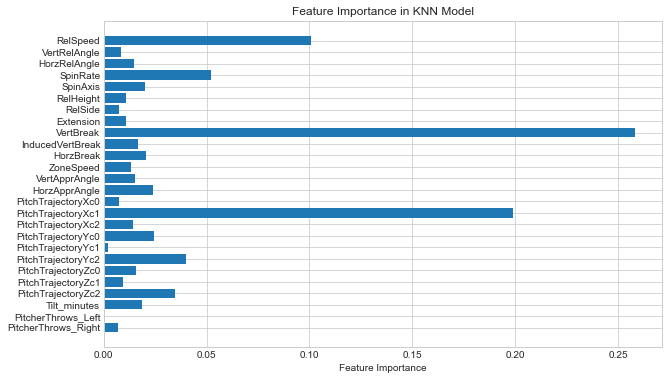

In [240]:
feature_names = X
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance, align='center')
plt.yticks(np.arange(len(feature_importance)), feature_names)
plt.xlabel('Feature Importance')
plt.title('Feature Importance in KNN Model')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

In [241]:
X = X.drop(["VertRelAngle", "PitchTrajectoryXc0",
            "PitchTrajectoryYc1", "PitcherThrows_Left"], axis = 1)

In [242]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 22)

# Decision Tree Optimized

After examining the baseline classifier models, decision tree performed the best with a ~0.8722 accuracy score. Now to test different ways to optimize for better performance.

Text(0, 0.5, 'Error Rate')

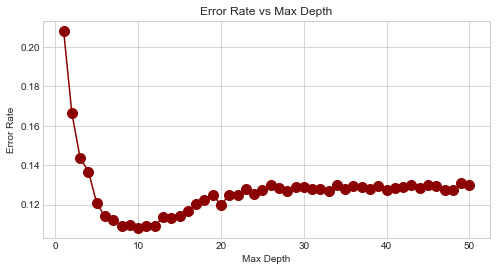

In [243]:
error_rate = []
for i in range(1,51):    
    dt = DecisionTreeClassifier(max_depth=i)
    dt.fit(X_train,y_train)
    pred_i = dt.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))
    
## creating a graph to examine which value for max_depth has the lowest error
plt.figure(figsize = (8,4))
plt.plot(range(1,51), error_rate,color = 'darkred', marker = 'o', markersize = 10)
plt.title('Error Rate vs Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Error Rate')

In [244]:
dt2 = DecisionTreeClassifier(max_depth = 10)
dt2.fit(X_train, y_train)
dt_pred = dt2.predict(X_test)
accuracy_score(y_test, dt_pred)

0.8928080622995878

In [245]:
parameters = {'criterion' : ['gini', 'entropy'],
              'max_depth' : range(0,50),
             'min_samples_split' : [2, 5, 10],
              'min_samples_leaf' : [1, 2, 5, 10, 15, 20],
              'max_features' : [None, 'log2', 'sqrt']
             }


grid_search = GridSearchCV(estimator = DecisionTreeClassifier(),
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 4,
                          n_jobs=-1,
                          verbose = 1)


In [246]:
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 5400 candidates, totalling 21600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 506 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 856 tasks      | elapsed:   52.4s
[Parallel(n_jobs=-1)]: Done 1306 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1856 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2506 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 3256 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 4106 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 5056 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 6106 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 7256 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done 8506 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done 9856 tasks      | elapsed: 23.6min
[Parallel(n_jobs=-1)]: Done 11630 tasks      |

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(0, 50),
                         'max_features': [None, 'log2', 'sqrt'],
                         'min_samples_leaf': [1, 2, 5, 10, 15, 20],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy', verbose=1)

In [247]:
best_params = grid_search.best_params_
print("The best parameters are:", best_params)

best_score = grid_search.best_score_
print("The accuracy:", best_score)

The best parameters are: {'criterion': 'entropy', 'max_depth': 8, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
The accuracy: 0.8871454433581051


In [248]:
print(classification_report(y_test, best_dt.predict(X_test)))

              precision    recall  f1-score   support

    ChangeUp       0.25      0.89      0.39       857
   Curveball       0.00      0.00      0.00       459
      Cutter       0.00      0.00      0.00       123
    Fastball       0.96      0.93      0.94      5840
      Slider       0.00      0.00      0.00      1453

    accuracy                           0.71      8732
   macro avg       0.24      0.36      0.27      8732
weighted avg       0.67      0.71      0.67      8732



/Users/jisoluawe/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
